In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from skimage.feature import hog
from random import shuffle
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import time
from scipy.ndimage.measurements import label

%matplotlib inline

## 1 Read Images

In [3]:
vehicle_images = []
non_vehicle_images = []

if (os.path.isfile('vehicle_images.npy') and os.path.isfile('non_vehicle_images.npy')):
    print('Loading pre-loaded array...')
    vehicle_images = np.load('vehicle_images.npy')
    non_vehicle_images = np.load('non_vehicle_images.npy')
else:
    for path, subdirs, files in os.walk('vehicles'):
        for name in files:
            if name.endswith('.png'):
#                 vehicle_images.append(cv2.cvtColor(cv2.imread(os.path.join(path, name)), cv2.COLOR_BGR2GRAY))
                vehicle_images.append(cv2.imread(os.path.join(path, name)))
    np.save('vehicle_images.npy', vehicle_images)
    for path, subdirs, files in os.walk('non-vehicles'):
        for name in files:
            if name.endswith('.png'):
                non_vehicle_images.append(cv2.imread(os.path.join(path, name)))
    np.save('non_vehicle_images.npy', non_vehicle_images)

                
print(len(vehicle_images))
shuffle(vehicle_images)
shuffle(non_vehicle_images)
vehicle_images_train = vehicle_images[:7500]
vehicle_images_eval = vehicle_images[7500:]
non_vehicle_images_train = non_vehicle_images[:7500]
non_vehicle_images_eval = non_vehicle_images[7500:]
print('# of non_vehicle_images: {}'.format(len(non_vehicle_images)))
print('# of non_vehicle_images_train: {}'.format(len(non_vehicle_images_train)))
print('# of non_vehicle_images_eval: {}'.format(len(non_vehicle_images_eval)))
print('# of vehicle_images: {}'.format(len(vehicle_images)))
print('# of vehicle_images_train: {}'.format(len(vehicle_images_train)))
print('# of vehicle_images_eval: {}'.format(len(vehicle_images_eval)))

Loading pre-loaded array...
8792
# of non_vehicle_images: 8968
# of non_vehicle_images_train: 7500
# of non_vehicle_images_eval: 1468
# of vehicle_images: 8792
# of vehicle_images_train: 7500
# of vehicle_images_eval: 1292


## 2 Hog Feature

In [4]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
# print(non_vehicle_images_eval[0].shape)
# print(len(single_img_features(non_vehicle_images_eval[0], color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)))

hog_non_vehicle_images_eval = []
if os.path.isfile('hog_non_vehicle_images_eval.npy'):
    print('Loading hog_non_vehicle_images_eval...')
    hog_non_vehicle_images_eval = np.load('hog_non_vehicle_images_eval.npy')
else:
    for image in non_vehicle_images_eval:
        features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        hog_non_vehicle_images_eval.append(features.flatten())
    np.save('hog_non_vehicle_images_eval.npy', hog_non_vehicle_images_eval)
    print('Saving hog_non_vehicle_images_eval...')


hog_non_vehicle_images_train = []
if os.path.isfile('hog_non_vehicle_images_train.npy'):
    print('Loading hog_non_vehicle_images_train...')
    hog_non_vehicle_images_train = np.load('hog_non_vehicle_images_train.npy')
else:
    for image in non_vehicle_images_train:
        features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        hog_non_vehicle_images_train.append(features.flatten())
    np.save('hog_non_vehicle_images_train.npy', hog_non_vehicle_images_train)
    print('Saving hog_non_vehicle_images_train...')

hog_vehicle_images_train = []
if os.path.isfile('hog_vehicle_images_train.npy'):
    print('Loading hog_vehicle_images_train...')
    hog_vehicle_images_train = np.load('hog_vehicle_images_train.npy')
else:
    for image in vehicle_images_train:
        features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        hog_vehicle_images_train.append(features.flatten())
    np.save('hog_vehicle_images_train.npy', hog_vehicle_images_train)
    print('Saving hog_vehicle_images_train...')
    
hog_vehicle_images_eval = []
if os.path.isfile('hog_vehicle_images_eval.npy'):
    print('Loading hog_vehicle_images_eval...')
    hog_vehicle_images_eval = np.load('hog_vehicle_images_eval.npy')
else:
    for image in vehicle_images_eval:
        features = single_img_features(image, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        hog_vehicle_images_eval.append(features.flatten())
    np.save('hog_vehicle_images_eval.npy', hog_vehicle_images_eval)
    print('Saving hog_vehicle_images_eval...')

Loading hog_non_vehicle_images_eval...
Loading hog_non_vehicle_images_train...
Loading hog_vehicle_images_train...
Loading hog_vehicle_images_eval...


## 3 Build SVM classifier 

In [5]:
NUM_TRAIN = 15000
train_features = np.vstack((hog_vehicle_images_train, hog_non_vehicle_images_train)).astype(np.float64)
train_features_scaler = StandardScaler().fit(train_features)
normalized_train_features = train_features_scaler.transform(train_features)

train_target = np.append(np.ones(len(hog_vehicle_images_train)), np.zeros(len(hog_non_vehicle_images_train)))

assert len(normalized_train_features) == len(train_target)
p1 = np.random.permutation(len(normalized_train_features))

train_target = train_target[p1]
normalized_train_features = normalized_train_features[p1]

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
time1 = time.time()
svr.fit(normalized_train_features[:NUM_TRAIN], train_target[:NUM_TRAIN])
time2 = time.time()
print('Train SVM function took %0.3f s' % (time2-time1))
# clf = grid_search.GridSearchCV(svr, parameters)
# clf.fit(train_features, train_target)

NUM_EVAL = 2760
eval_features = np.vstack((hog_vehicle_images_eval, hog_non_vehicle_images_eval)).astype(np.float64)
normalized_eval_features = train_features_scaler.transform(eval_features)
eval_target = np.append(np.ones(len(hog_vehicle_images_eval)), np.zeros(len(hog_non_vehicle_images_eval)))

assert len(normalized_eval_features) == len(eval_target)
p2 = np.random.permutation(len(normalized_eval_features))

normalized_eval_features = normalized_eval_features[p2]
eval_target = eval_target[p2]

predictions = svr.predict(normalized_eval_features[:NUM_EVAL])

print('Precision: {}'.format(sum(predictions == eval_target[:NUM_EVAL])/float(NUM_EVAL)))

Train SVM function took 208.918 s
Precision: 0.9851449275362318


## 4 Sliding Window

In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [27]:
test_images = []
for file in os.listdir('test_images'):
    if file.endswith('.jpg'):
        test_image = cv2.imread(os.path.join('test_images', file))
        test_images.append(test_image)
print(len(test_images))

frame_images = []
for file in os.listdir('frames'):
    if file.endswith('.jpg'):
        frame_image = cv2.imread(os.path.join('frames', file))
        frame_images.append(frame_image)
print(len(frame_images))

6
125


In [28]:
print(len(test_images))
print(len(frame_images))

6
125


Processing 0/125 image...


/Users/bwuzhang/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Processing 1/125 image...
Processing 2/125 image...
Processing 3/125 image...
Processing 4/125 image...
Processing 5/125 image...
Processing 6/125 image...
Processing 7/125 image...
Processing 8/125 image...
Processing 9/125 image...
Processing 10/125 image...
Processing 11/125 image...
Processing 12/125 image...
Processing 13/125 image...
Processing 14/125 image...
Processing 15/125 image...
Processing 16/125 image...
Processing 17/125 image...
Processing 18/125 image...
Processing 19/125 image...
Processing 20/125 image...


/Users/bwuzhang/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Processing 21/125 image...
Processing 22/125 image...
Processing 23/125 image...
Processing 24/125 image...
Processing 25/125 image...
Processing 26/125 image...
Processing 27/125 image...
Processing 28/125 image...
Processing 29/125 image...
Processing 30/125 image...
Processing 31/125 image...
Processing 32/125 image...
Processing 33/125 image...
Processing 34/125 image...
Processing 35/125 image...
Processing 36/125 image...
Processing 37/125 image...
Processing 38/125 image...
Processing 39/125 image...
Processing 40/125 image...
Processing 41/125 image...
Processing 42/125 image...
Processing 43/125 image...
Processing 44/125 image...
Processing 45/125 image...
Processing 46/125 image...
Processing 47/125 image...
Processing 48/125 image...
Processing 49/125 image...
Processing 50/125 image...


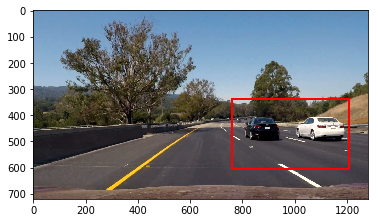

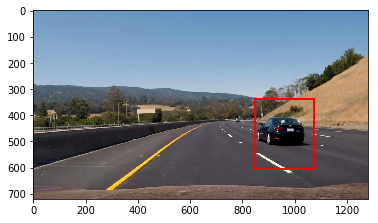

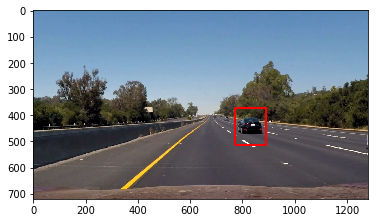

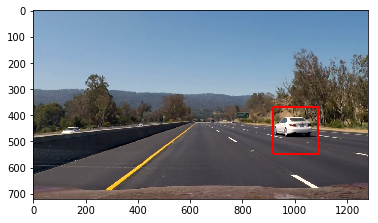

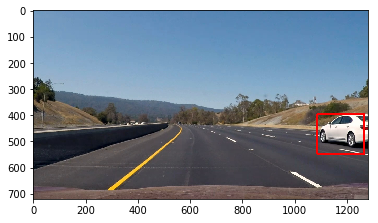

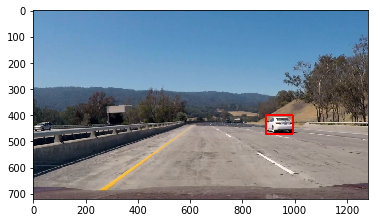

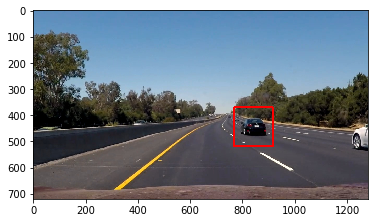

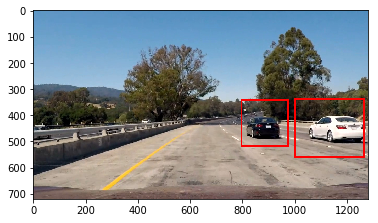

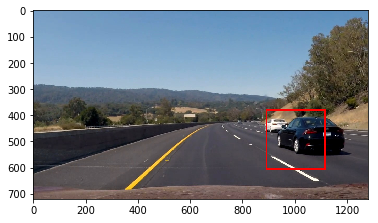

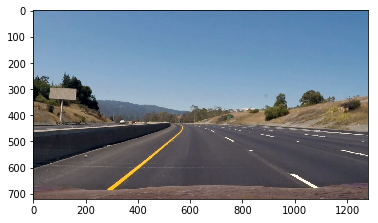

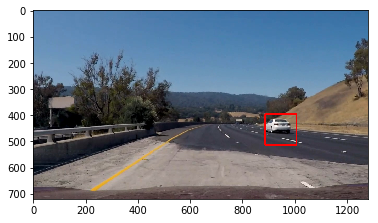

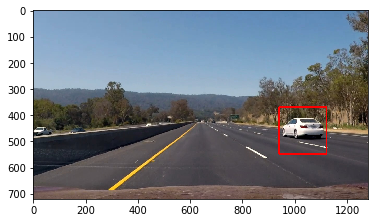

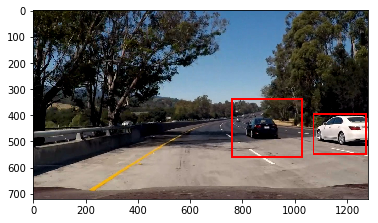

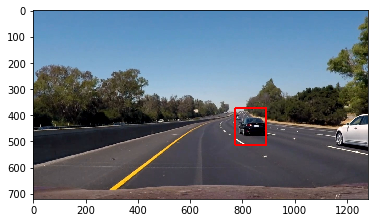

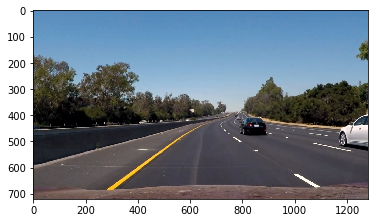

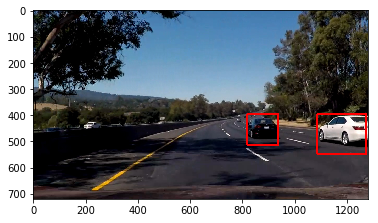

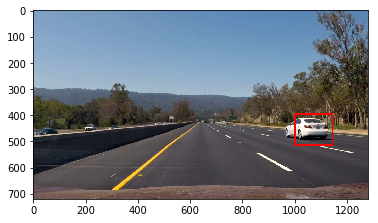

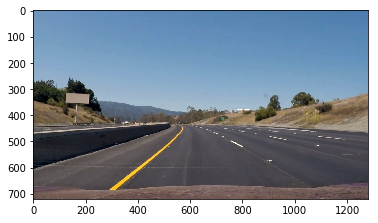

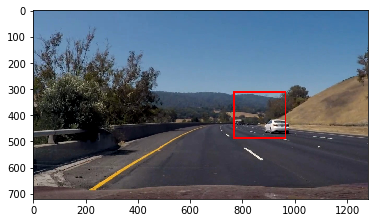

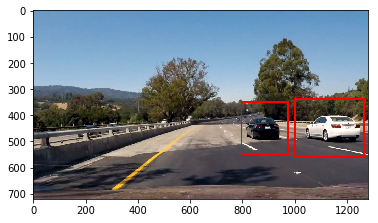

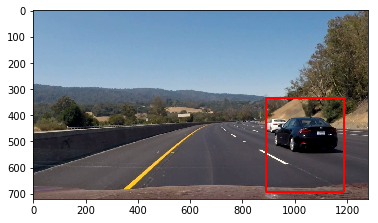

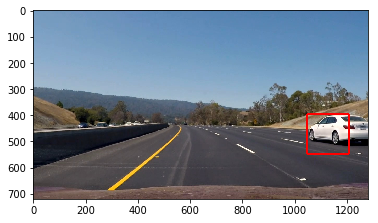

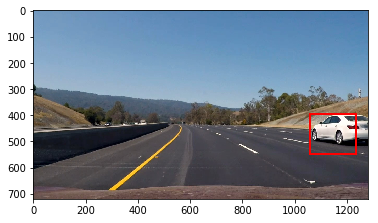

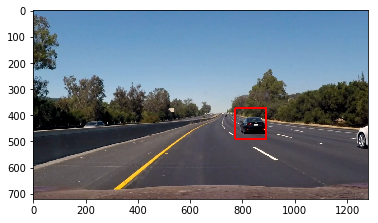

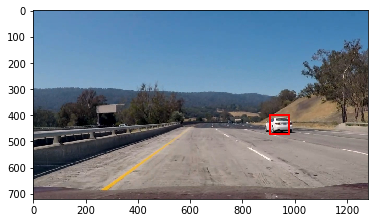

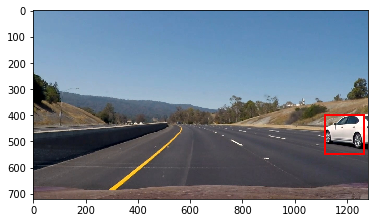

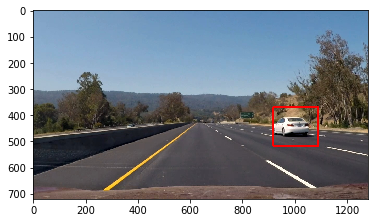

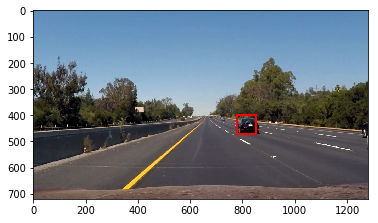

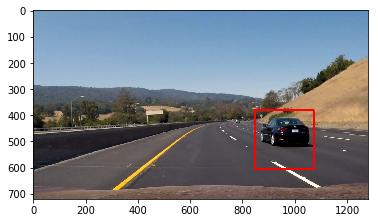

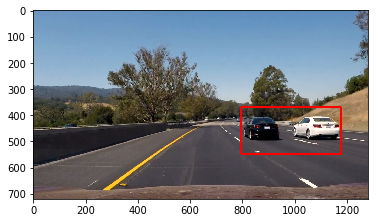

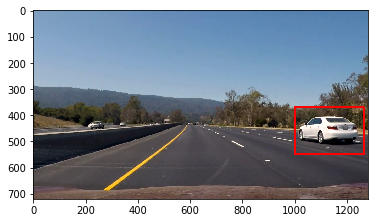

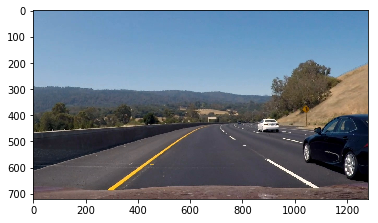

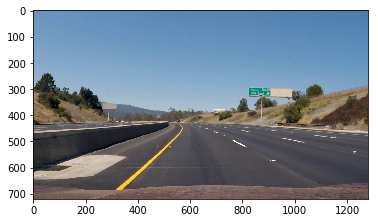

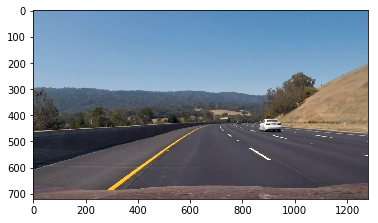

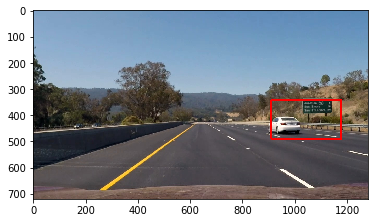

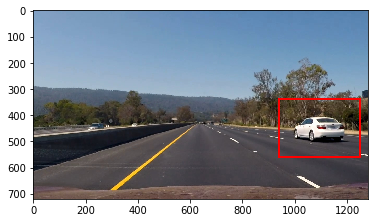

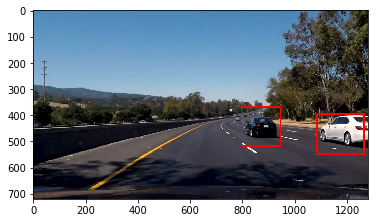

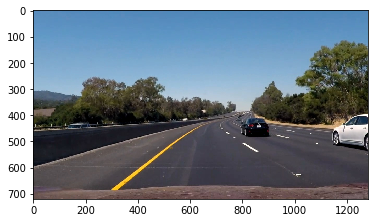

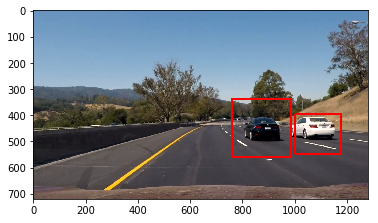

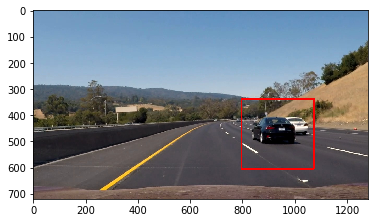

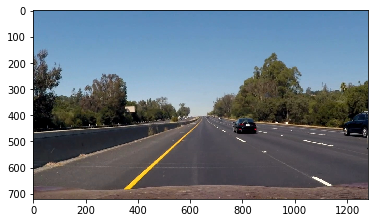

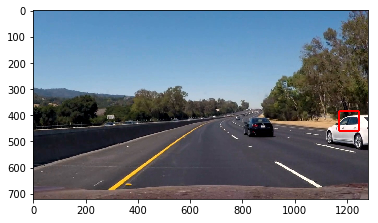

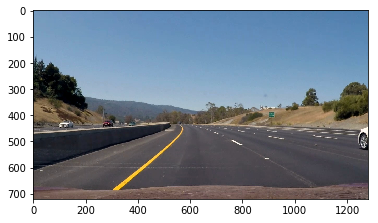

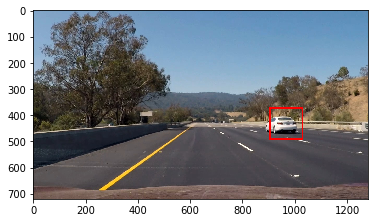

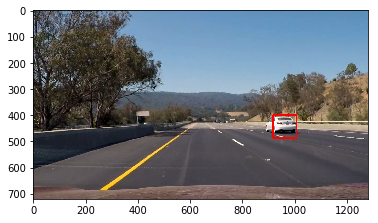

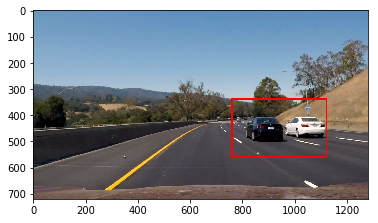

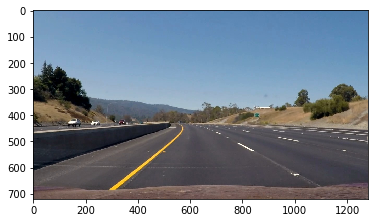

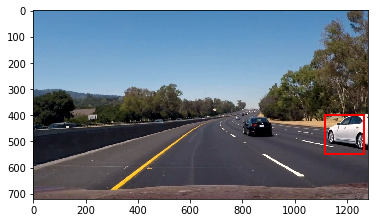

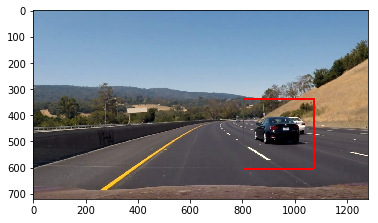

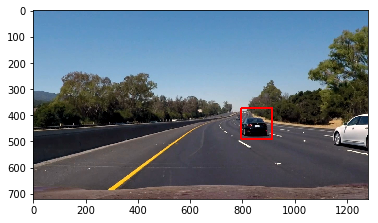

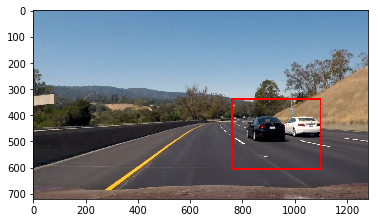

In [35]:
x_overlap = 0.8
y_overlap = 0.8

def pipeline(image):
    imcopy = np.copy(image)
    windows = []
#     windows.extend(slide_window(image, x_start_stop=[830, test_images[0].shape[1]], 
#                            y_start_stop=[350, test_images[0].shape[0]], 
#                            xy_window=(300, 300), xy_overlap=(x_overlap, y_overlap)))
#     windows.extend(slide_window(image, x_start_stop=[716, test_images[0].shape[1]], 
#                            y_start_stop=[350, 370+225], 
#                            xy_window=(225, 225), xy_overlap=(x_overlap, y_overlap)))
#     windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
#                            y_start_stop=[350, 370+150], 
#                            xy_window=(150, 150), xy_overlap=(x_overlap, y_overlap)))
#     windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
#                            y_start_stop=[380, 380+100], 
#                            xy_window=(100, 100), xy_overlap=(x_overlap, y_overlap)))
#     windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
#                            y_start_stop=[390, 390+100], 
#                            xy_window=(75, 75), xy_overlap=(x_overlap, y_overlap)))
    windows.extend(slide_window(image, x_start_stop=[830, test_images[0].shape[1]], 
                           y_start_stop=[350-75, test_images[0].shape[0]], 
                           xy_window=(300, 300), xy_overlap=(x_overlap, y_overlap)))
    windows.extend(slide_window(image, x_start_stop=[716, test_images[0].shape[1]], 
                           y_start_stop=[350-57, 370+225+58], 
                           xy_window=(225, 225), xy_overlap=(x_overlap, y_overlap)))
    windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
                           y_start_stop=[350-38, 370+150+38], 
                           xy_window=(150, 150), xy_overlap=(x_overlap, y_overlap)))
    windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
                           y_start_stop=[380-30, 380+100+60], 
                           xy_window=(120, 120), xy_overlap=(x_overlap, y_overlap)))
    windows.extend(slide_window(image, x_start_stop=[680, test_images[0].shape[1]], 
                           y_start_stop=[390-19, 390+100+38], 
                           xy_window=(75, 75), xy_overlap=(x_overlap, y_overlap)))
    prediction_windows = []
    for i, window in enumerate(windows):
#         cv2.rectangle(imcopy, window[0], window[1], (0, 0, 255), 6)
        img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        feature = single_img_features(img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        normalized_feature = train_features_scaler.transform(feature.flatten().reshape([1,-1]))
        if svr.predict(normalized_feature) == 1:
            prediction_windows.append(window)
    heatmap = np.zeros((720, 1280))
    
    for prediction_window in prediction_windows:
        heatmap[prediction_window[0][1]:prediction_window[1][1], prediction_window[0][0]:prediction_window[1][0]] += 1
        
    labels = label(heatmap)
    
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    
    return imcopy
    
for j, image in enumerate(frame_images):
    if j > 50:
        break
    print('Processing {}/{} image...'.format(j, len(frame_images)))
    plt.figure()
    plt.imshow(cv2.cvtColor(pipeline(image), cv2.COLOR_BGR2RGB))

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  0%|          | 4/1261 [00:24<2:05:50,  6.01s/it]

KeyboardInterrupt: 